# Import modules

In [1]:
#!/usr/bin/pythonpy
################################################################################
# PYTHON's MODULAE
# ------------------------------------------------------------------------------
################################################################################
import os
import sys
module_path = os.path.abspath(os.path.join('/lib/python3.8/site-packages'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import fortran_integral
# import fortran_quad
import numpy as np
from numpy import sqrt as sqrt
from numpy import pi as pi

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colorbar as colorb
import pickle 
import datetime
from matplotlib import colors

# Total cross sections
# Total cross sections
sys.path.append('../app/')
if module_path not in sys.path:
    sys.path.append(module_path)
import models.sigma0_xsections as sig0
import models.general_parameters as gp
import models.relic_density_calc as ohm
import models.radiative_factorization as hp
import models.pdf_integration as qcd
import utils.colorb_2D as cb2d
import lhapdf  


#################################################
today = datetime.date.today().strftime('%Y-%m-%d')
today = '2024-01-03'  ##  for run vesions

## Some configurations

sigmaz = {}
## Geral parameters
brn = gp.brn
grx0 = gp.grx0 
glx0 = gp.glx0
gx0 = gp.gx0

dmnames = sig0.dmnames
smax = gp.smax
me = gp.mvec[0]

Mmed = gp.Mmed  # TeV
mx  = gp.mx #  0.80 * Mmed/2  DM mass [TeV]
Nf_ee = gp.Nf_ee 
Nf_qq = gp.Nf_qq

newdm_list = ['Vector']


## For plots, just load this

In [1]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('/lib/python3.10/site-packages'))
# sys.path.append('../app/')
# if module_path not in sys.path:
#     sys.path.append(module_path)
# import utils.colorb_2D as cb2d
# import models.general_parameters as gp
# newdm_list = ['Scalar', 'Fermion']
# today = '2024-01-03' ##  for run vesions

In [2]:
# Define then ew colormap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = plt.colormaps['twilight']
colorsmod = [cmap(i) for i in range(cmap.N)]
new_colors = colorsmod[0:len(colorsmod) - 300] #= plt.get_cmap('Reds')(256)  # Change the last color to red
new_cmap_ee = ListedColormap(new_colors, name='modified_twilight')

---
---
# 1 - $e^{+}e^{-}$ interaction

## Relic

### Gondolo - relic

In [2]:
binsize_ohm = 70
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2 # (Mmed/2)*0.90 # DM mass [TeV]
smax = Mmed**2

gr_arr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx_arr = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr_arr, gx_arr) 

omegarelic_coup = {}
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(newdm_list):

    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
    
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x)
            print('done with', dmname, cp)
        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x)
            print('done with', dmname, cp)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x)
            print('done with', dmname, cp)


    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')
    print(f'Done for {dmname}')



done with Vector V
done with Vector AV
done with Vector CHR
Objeto salvo em ./myruns/2024-01-03_omegarelic_coup_ee_Vector_binsize_70_mx_1.2.pkl
Done for Vector


### naive relic

In [5]:
binsize_ohm = 100
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = (Mmed/2)*0.90 # DM mass [TeV]

smax = 4*mx**2

gr_arr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx_arr = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr_arr, gx_arr) 

omegarelic_coup = {}
print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(newdm_list):

    scalar_null = 0 if dmname != 'Fermion' else 1
    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
    
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x) * scalar_null

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x) * 0 * scalar_null

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x) * scalar_null


    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_supernaive_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
Objeto salvo em ./myruns/2024-01-03_supernaive_omegarelic_coup_ee_Scalar_binsize_100_mx_1.35.pkl
Done for Scalar


/mnt/c/Users/Marcio/resonant-dm-relic/notebooks/../app/models/relic_density_calc.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  Ohm_h2 = prefact / denom
/home/marcio/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: divide by zero encountered in super_naive (vectorized)
  outputs = ufunc(*inputs)
/tmp/ipykernel_26766/638394443.py:42: RuntimeWarning: invalid value encountered in multiply
  omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x) * 0 * scalar_null


Objeto salvo em ./myruns/2024-01-03_supernaive_omegarelic_coup_ee_Fermion_binsize_100_mx_1.35.pkl
Done for Fermion


## ee - Plots

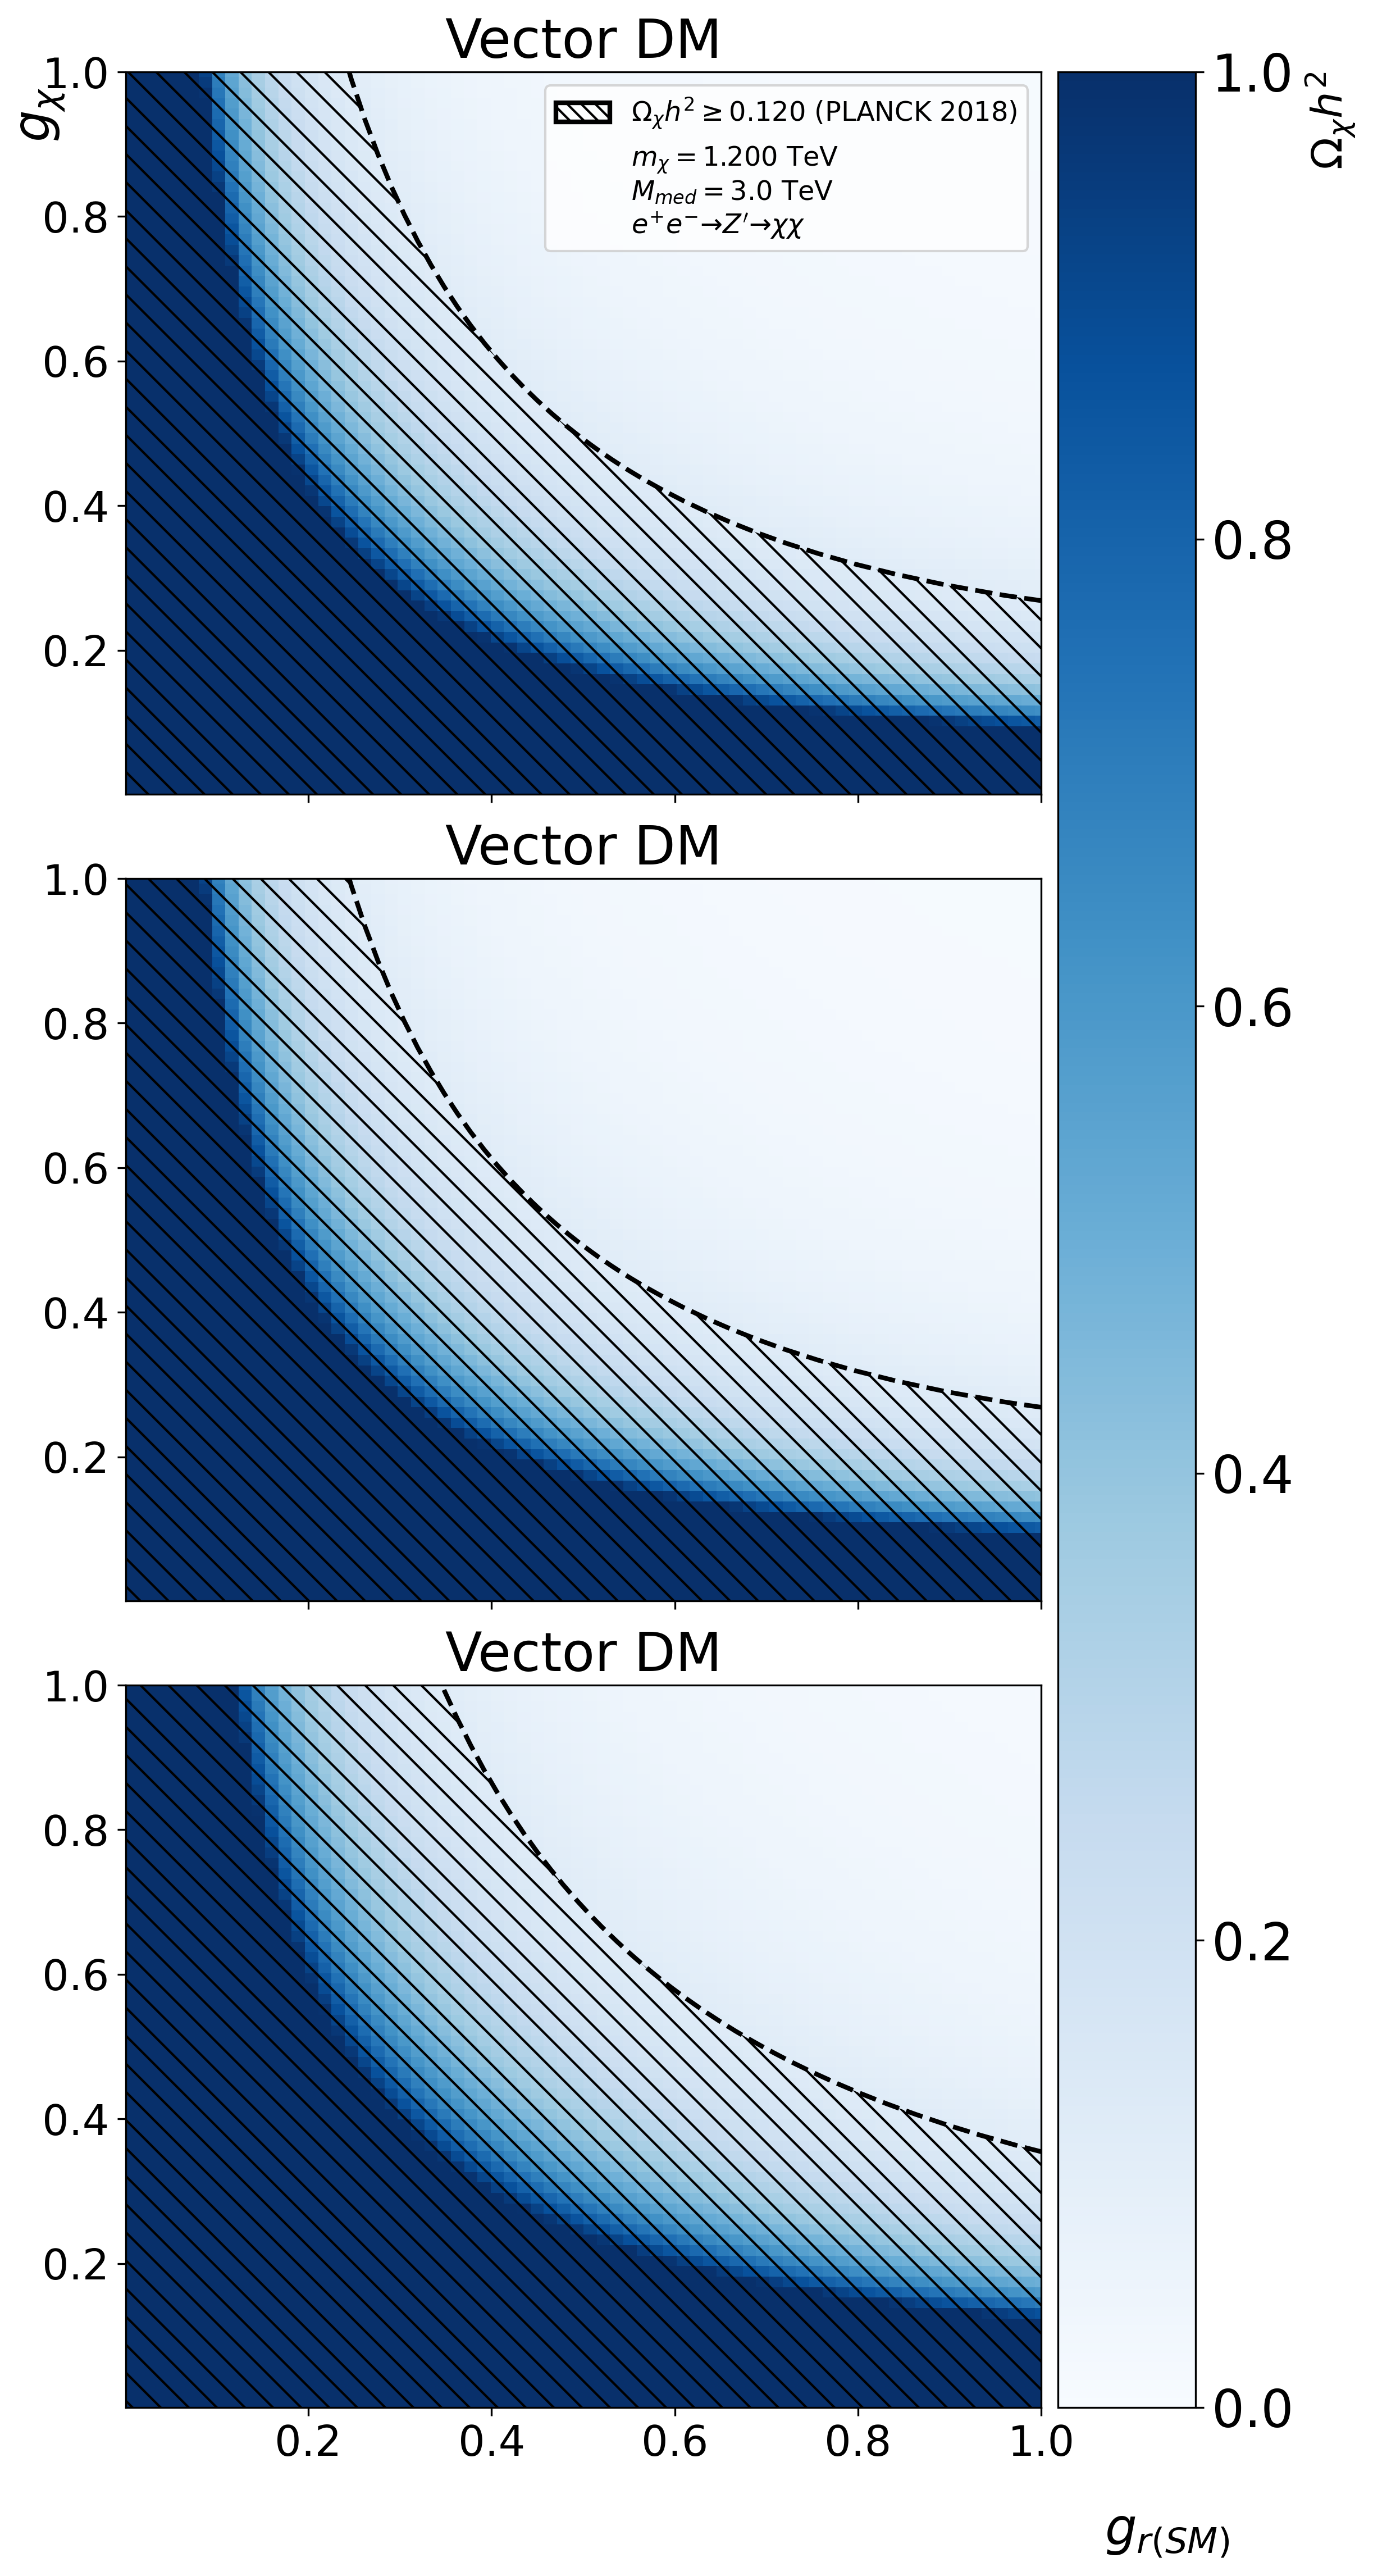

In [4]:
process = 'ee'
binsize_ohm = 70
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2 #(Mmed/2)*0.90 # DM mass [TeV]
omegarelic_coup = {}
for dmname in newdm_list:
    omegarelic_coup[dmname]  = gp.load_obj(f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')


## --------------------------------------------------------------------------------------------------------------------------------------------------------

# process = 'ee'
# binsize_ohm = 100
# mx = (Mmed/2)*0.90 # DM mass [TeV]
# omegarelic_coup2 = {}
# for dmname in newdm_list:
#     omegarelic_coup2[dmname]  = gp.load_obj(f'./myruns/{today}_supernaive_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')


## --------------------------------------------------------------------------------------------------------------------------------------------------------
    

    
cb2d.cb_coupling_relic(process, f'omega-relic-{process}-coup_mx_{mx}',  omegarelic_coup, newdm_list, folder = '../figures/vector-plots', figsize=(10, 18))

## XSEC - Couplings

In [9]:
binsize = 100
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2 #(Mmed/2)*0.90 # DM mass [TeV]
#mx = 1.350
smax = Mmed**2
gr_arr = np.linspace(1E-3, 1.0, binsize) # right SM/DM coupling
gx_arr = np.linspace(1E-3, 1.0, binsize) # DM coupling
# Define a grid
gx_grid, gr_grid = np.meshgrid(gx_arr, gr_arr) 

print('Doing coupling...')

#  ## axial: gl = -gr ## chiral: gl = 0
process = 'ee'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq

@np.vectorize
def sigmap(s, mq, Mmed, mx, gr, gl, gx, Nf_x):
    sigmatot =  hp.HPhsig(s, mq, Mmed, mx, gr, gl, gx, sig0.SFV(dmname).sig0, Nf_x) 
    return sigmatot 

sigmaz = {}

for fignumber, dmname in enumerate(newdm_list):

    sigmaz[dmname] = {}

    for cp in gp.cps:
    
        sigmaz[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, gr_grid, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, -gr_grid, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sigmaz[dmname][cp]['data'] = sigmap(smax, me, Mmed, mx, gr_grid, 0, gx_grid, Nf_x)
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)


    gp.save_obj(sigmaz[dmname], f'./myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}_mx_{mx}.pkl')
    print(f'Done for {dmname}')



Doing coupling...


/tmp/ipykernel_1082/3226029198.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)
/tmp/ipykernel_1082/3226029198.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), 

Objeto salvo em ./myruns/2024-01-03_sigmaz_coup_ee_Vector_binsize_100_mx_1.2.pkl
Done for Vector


/tmp/ipykernel_1082/3226029198.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[dmname][cp]['data'][:, :]), dtype=np.float)


### XSEC - Plot

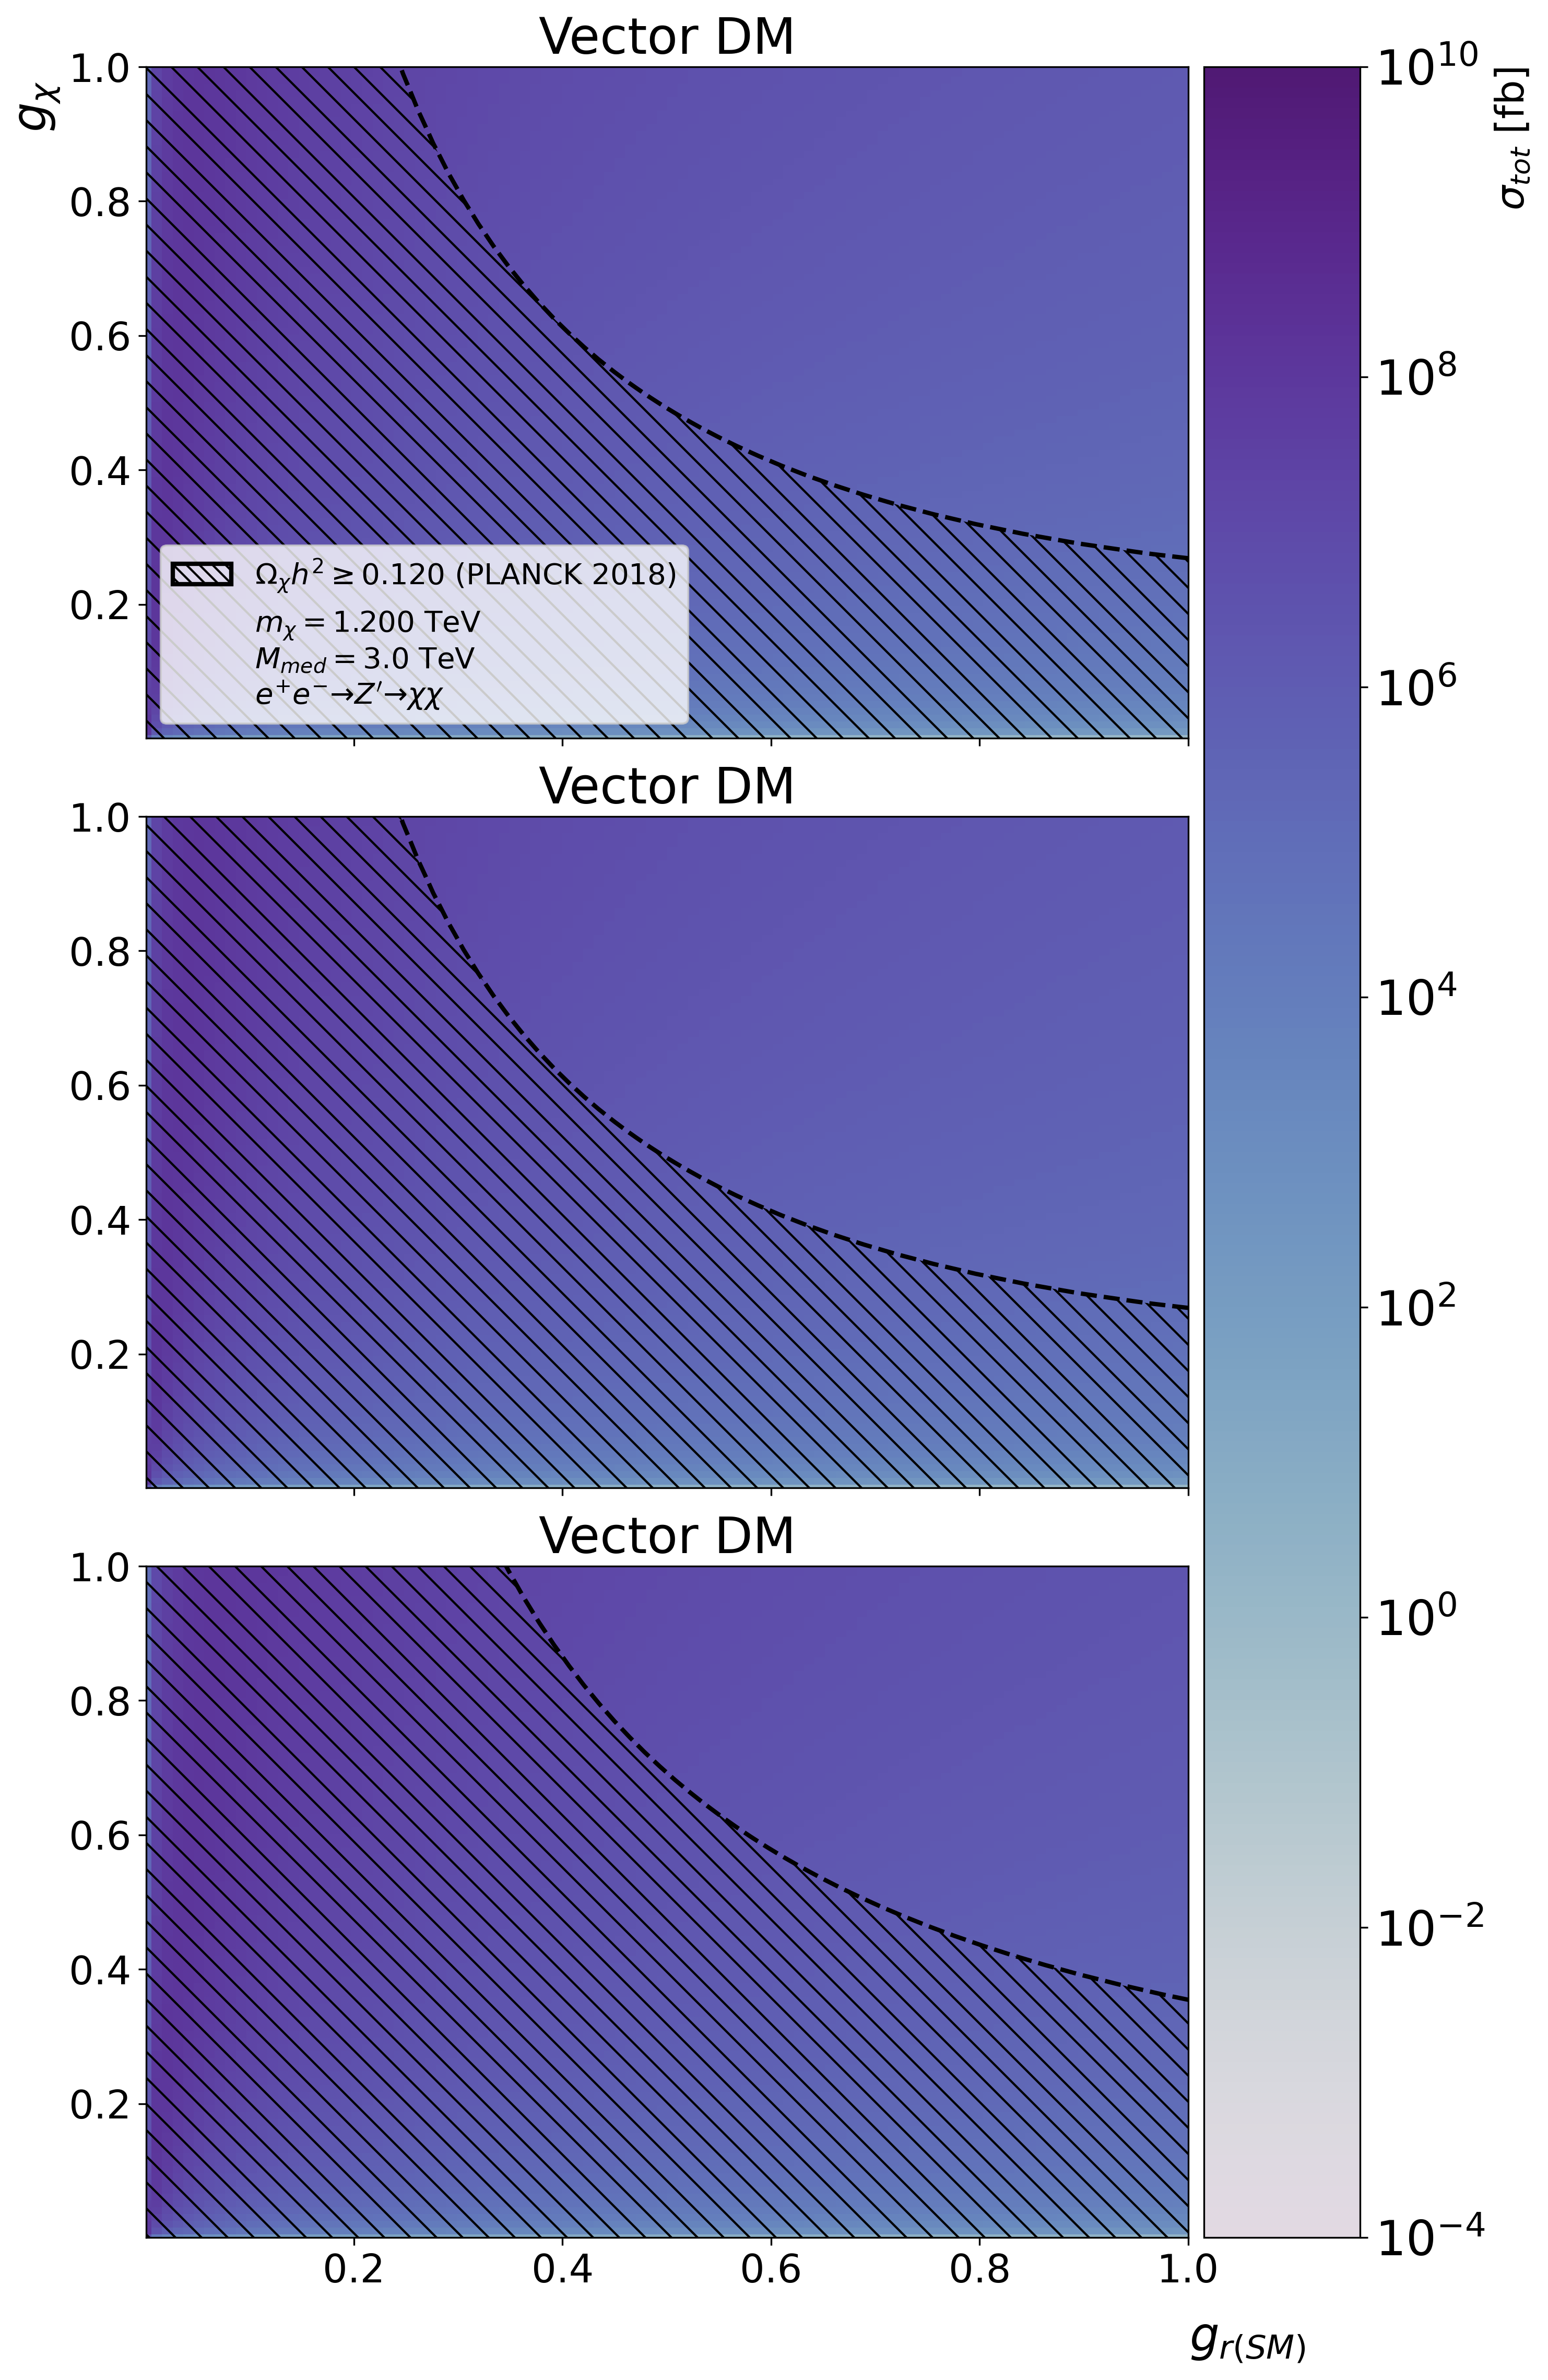

In [3]:
## --------------------------------------------------------------------------------------------------------------------------------------------------------
# resonant relic
process = 'ee'
binsize_ohm = 70
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2 # (Mmed/2)*0.90 # DM mass [TeV]
omegarelic_coup = {}
for dmname in newdm_list:
    omegarelic_coup[dmname]  = gp.load_obj(f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')



## --------------------------------------------------------------------------------------------------------------------------------------------------------
# Naive relic
# process = 'ee'
# binsize_ohm = 100
# mx = (Mmed/2)*0.90 # DM mass [TeV]
# omegarelic_coup2 = {}
# for dmname in newdm_list:
#     omegarelic_coup2[dmname]  = gp.load_obj(f'./myruns/{today}_supernaive_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')



## --------------------------------------------------------------------------------------------------------------------------------------------------------
# xsec relic
binsize = 100
mx = 1.2 # (Mmed/2)*0.90 # DM mass [TeV]
sigmaz = {}
for dmname in newdm_list:
    sigmaz[dmname]  = gp.load_obj(f'./myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}_mx_{mx}.pkl')



## --------------------------------------------------------------------------------------------------------------------------------------------------------

cb2d.cb_coupling(process, f'coupxcoup-{process}-ISR_mx_{mx}', sigmaz, omegarelic_coup, newdm_list, fix_scale=True, folder = '../figures/vector-plots', cmap=new_cmap_ee, vmin=10**-4, vmax=10**10, figsize=(10, 18),)

---
---
---
#  $q \bar q$ interaction 

## Relic

### naive relic

In [20]:
binsize_ohm = 100
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2# (Mmed/2)*0.90 # DM mass [TeV]
#mx = 1.350 # DM mass [TeV]
smax = 4*mx**2

gr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

omegarelic_coup = {}
print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(newdm_list):

    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
        scalar_null = 0 if dmname != 'Fermion' else 1
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x) * scalar_null

        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x) * scalar_null * 0

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x) * scalar_null


    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_supernaive_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
Objeto salvo em ./myruns/2024-01-03_supernaive_omegarelic_coup_qq_Scalar_binsize_100_mx_1.35.pkl
Done for Scalar


/mnt/c/Users/Marcio/resonant-dm-relic/notebooks/../app/models/relic_density_calc.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  Ohm_h2 = prefact / denom
/home/marcio/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: divide by zero encountered in super_naive (vectorized)
  outputs = ufunc(*inputs)
/tmp/ipykernel_18469/2075120807.py:41: RuntimeWarning: invalid value encountered in multiply
  omegarelic_coup[dmname][cp]['data'] = ohm.super_naive(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x) * scalar_null * 0


Objeto salvo em ./myruns/2024-01-03_supernaive_omegarelic_coup_qq_Fermion_binsize_100_mx_1.35.pkl
Done for Fermion


### gondolo - relic

In [3]:
binsize_ohm = 70
###################################################
###################################################
## storage \sigma grid in z
Mmed = 3.0  # mediator mass [TeV]
mx = 1.2 #(Mmed/2)*0.90 # DM mass [TeV]
#mx = 1.350 # DM mass [TeV]
smax = Mmed**2

gr = np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling
gx = np.linspace(1E-3, 1, binsize_ohm) # DM coupling

# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

omegarelic_coup = {}
print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 

for fignumber, dmname in enumerate(newdm_list):

    omegarelic_coup[dmname] = {}

    for cp in gp.cps:
    
        omegarelic_coup[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x)
            print('done for ', dmname, cp)
        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x)
            print('done for ', dmname, cp)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][cp]['data'] = ohm.Ohm_numerical(smax, me, Mmed , mx, gr_grid, 0, gx_grid, dmname, Nf_x)
            print('done for ', dmname, cp)


    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
done for  Vector V
done for  Vector AV
done for  Vector CHR
Objeto salvo em ./myruns/2024-01-03_omegarelic_coup_qq_Vector_binsize_70_mx_1.2.pkl
Done for Vector


### relic qq - plot

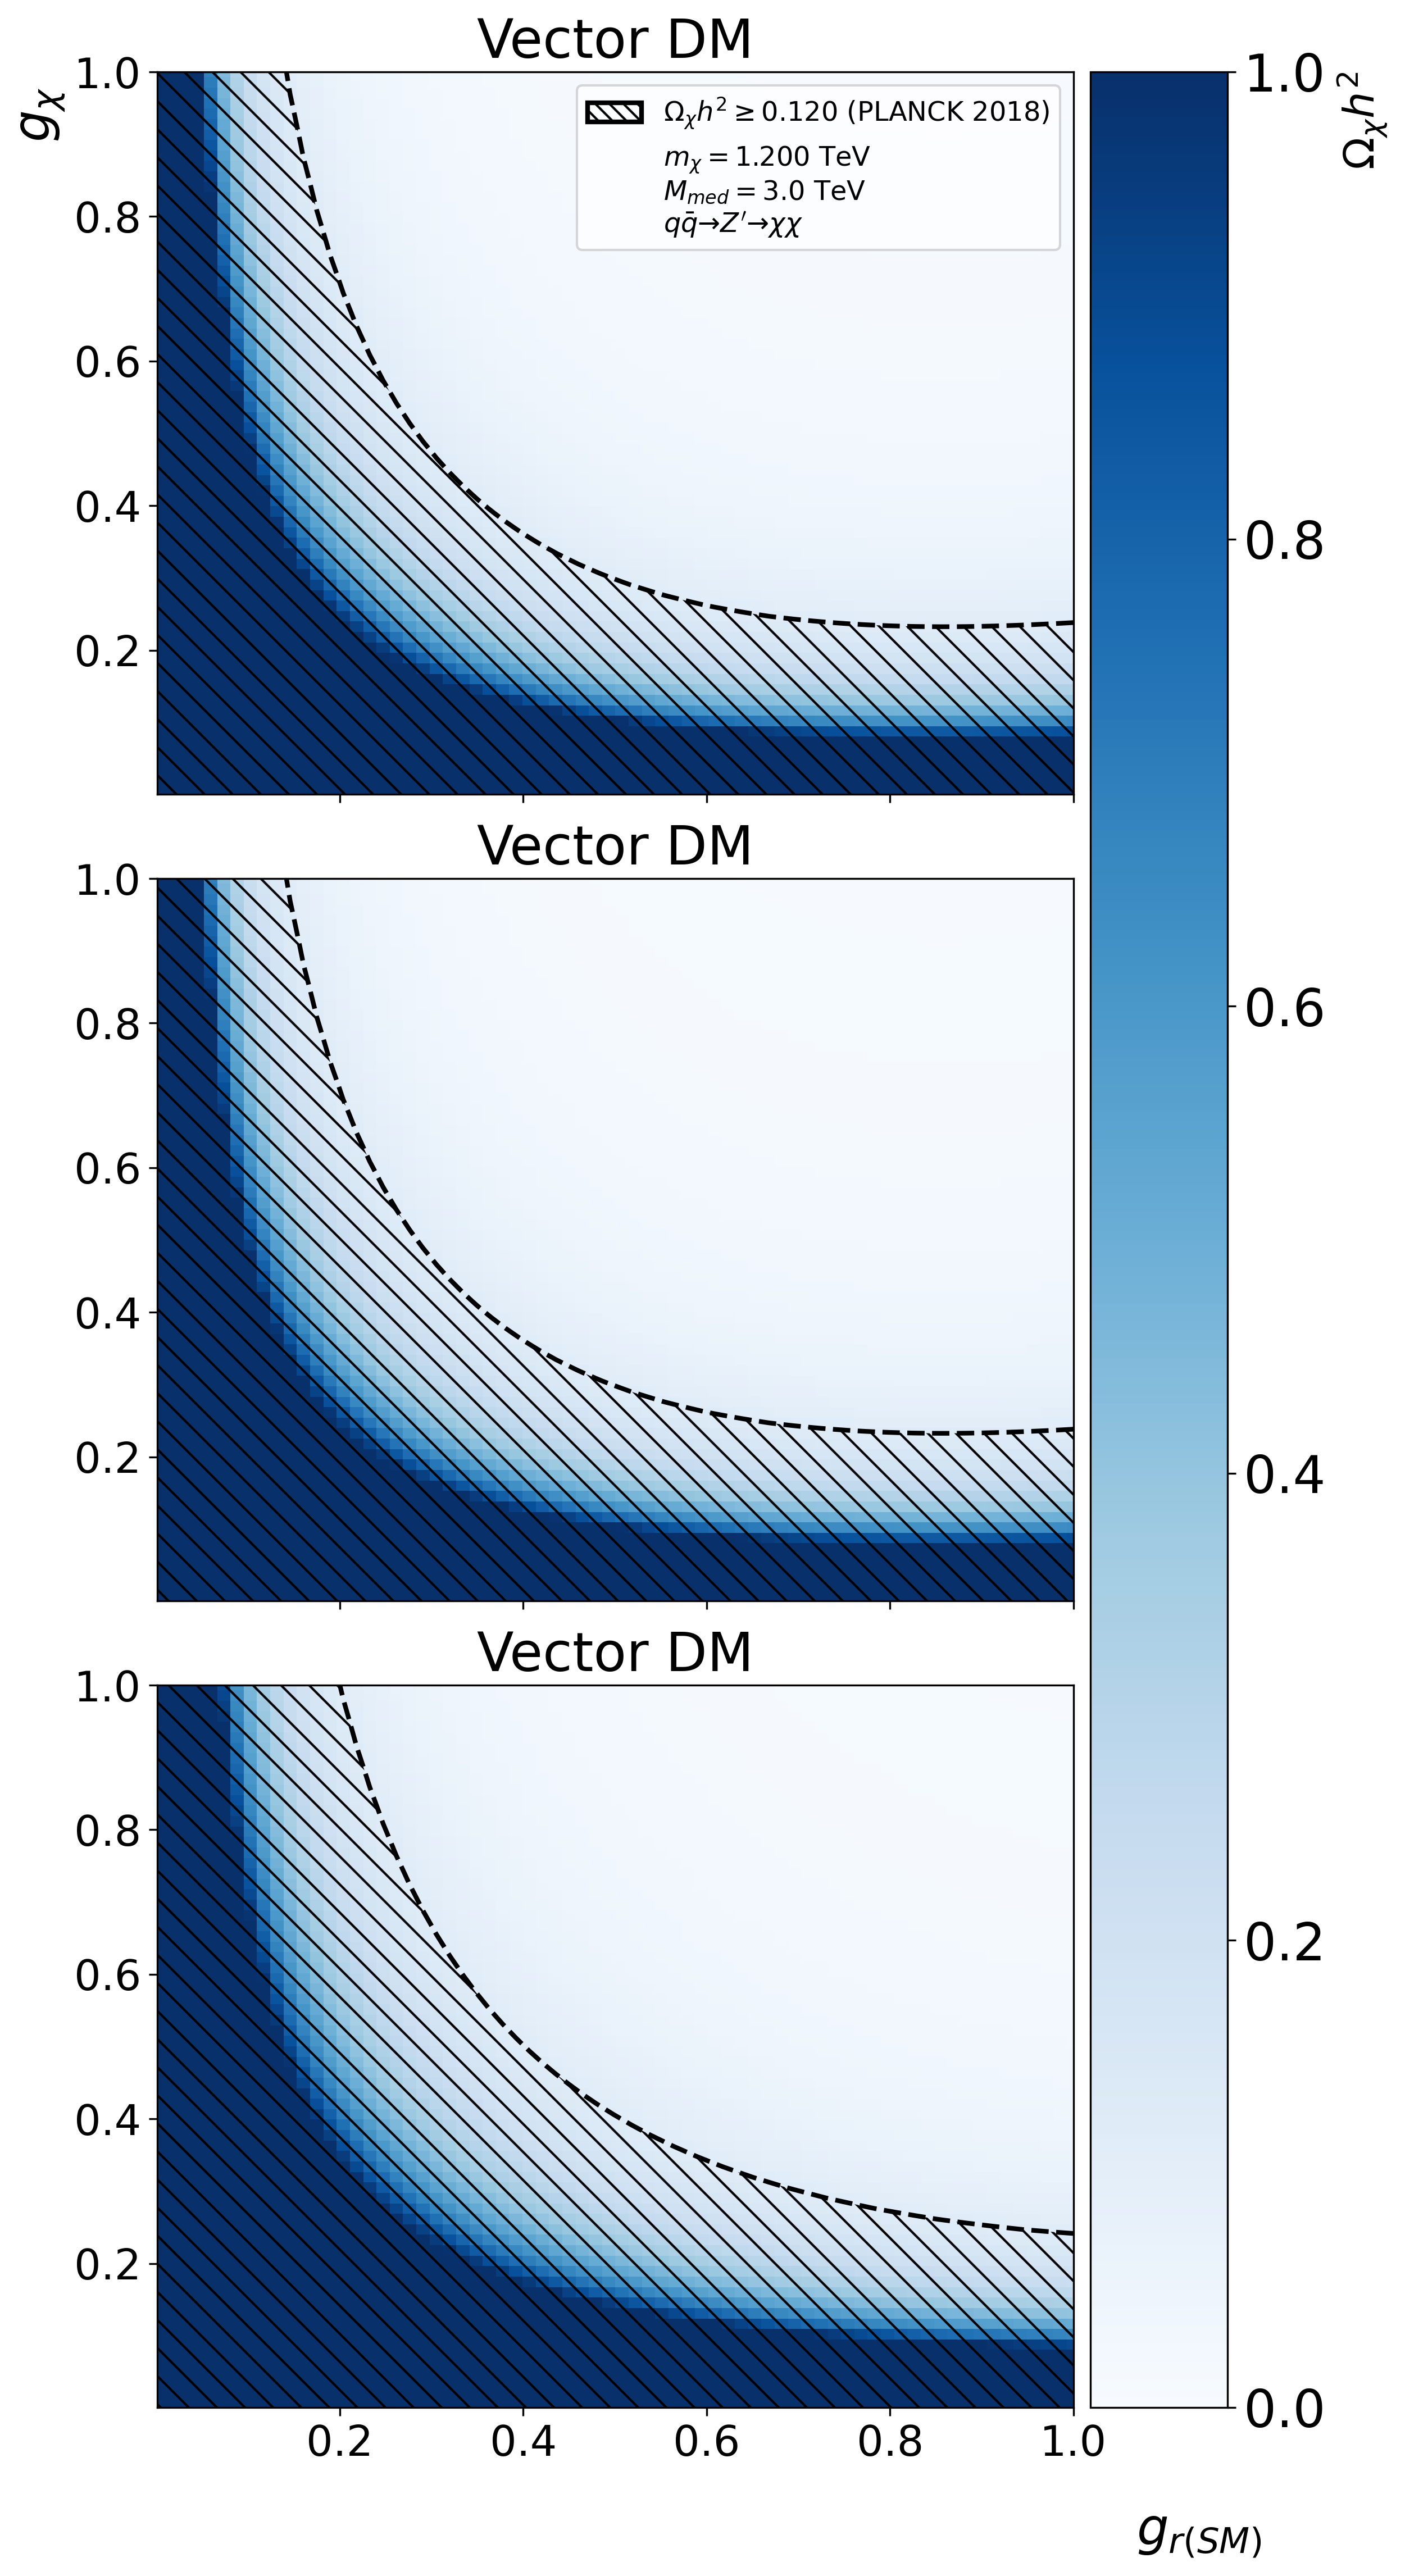

In [3]:
process = 'qq'
binsize_ohm = 70
mx = 1.2 #(Mmed/2)*0.90 # DM mass [TeV]
omegarelic_coup = {}
for dmname in newdm_list:
    omegarelic_coup[dmname]  = gp.load_obj(f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')


## --------------------------------------------------------------------------------------------------------------------------------------------------------

# process = 'qq'
# binsize_ohm = 100
# mx = (Mmed/2)*0.90 # DM mass [TeV]
# omegarelic_coup2 = {}
# for dmname in newdm_list:
#     omegarelic_coup2[dmname]  = gp.load_obj(f'./myruns/{today}_supernaive_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')


## --------------------------------------------------------------------------------------------------------------------------------------------------------
    

    
cb2d.cb_coupling_relic(process, f'omega-relic-{process}-coup_mx_{mx}', omegarelic_coup, newdm_list, folder = '../figures/vector-plots', figsize=(10, 18))

## XSEC - qq - Coupling

In [23]:
binsize = 100

gr = np.linspace(1E-3, 1.0, binsize) # right SM/DM coupling
gx = np.linspace(1E-3, 1.0, binsize) # DM coupling
# Define a grid
gr_grid, gx_grid = np.meshgrid(gr, gx) 

#define pdf
PDF_sets = ['CT10', 'NNPDF31_lo_as_0118', 'CT18NLO', 'MMHT2014lo68cl', 'PDF4LHC15_nlo_100']
pdf = lhapdf.mkPDF(PDF_sets[1], 0)
s_max = (14)**2 
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq
sigmaz = {}
sighat_hphoton = {}

Mmed = 3.0  # mediator mass [TeV]
mx = 1.200 #(Mmed/2)*0.90 # DM mass [TeV]


for fignumber, dmname in enumerate(newdm_list):

    sigmaz[dmname] = {}
    sighat_hphoton[dmname] = {}
    sig0funcs = sig0.SFV(dmname).sig0

    for cp in gp.cps:
    
        sigmaz[dmname][cp] = {}
        sighat_hphoton[dmname][cp] = {}

        if cp == 'V': #vetorial: gl = gr 
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, gr_grid, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, gr_grid, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)


        elif cp == 'AV': # axial: gl = -gr
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, -gr_grid, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, -gr_grid, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, -gr_grid, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)

        else: # chiral: gl = 0
            param_lst = [smax, gp.me, Mmed, mx, gr_grid, 0, gx_grid, dmname, Nf_x]
            sigmaz[dmname][cp]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            sighat_hphoton[dmname][cp] = hp.HPhsig(Mmed**2, me, Mmed, mx, gr_grid, 0, gx_grid, sig0funcs, Nf_x)
            sigmaz[dmname][cp]['data'] = qcd.dsigdM2_ISR(pdf, s_max, (Mmed)**2/s_max, Mmed, 1, mx, gr_grid, 0, gx_grid, sighat_hphoton[dmname][cp])
            sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)


    gp.save_obj(sigmaz[dmname], f'./myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}_mx_{mx}.pkl')
    print(f'Done for {dmname}')


LHAPDF 6.5.3 loading /share/LHAPDF/NNPDF31_lo_as_0118/NNPDF31_lo_as_0118_0000.dat
NNPDF31_lo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 315000


/tmp/ipykernel_18287/3762841285.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)
/tmp/ipykernel_18287/3762841285.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['dat

Objeto salvo em ./myruns/2024-01-03_sigmaz_coup_qq_Vector_binsize_100_mx_1.2.pkl
Done for Vector


/tmp/ipykernel_18287/3762841285.py:55: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sigmaz[dmname][cp]['data'] = np.array(list(sigmaz[f'{dmname}'][cp]['data'][:, :]), dtype=np.float)


### xsec - coupling - qq - plots

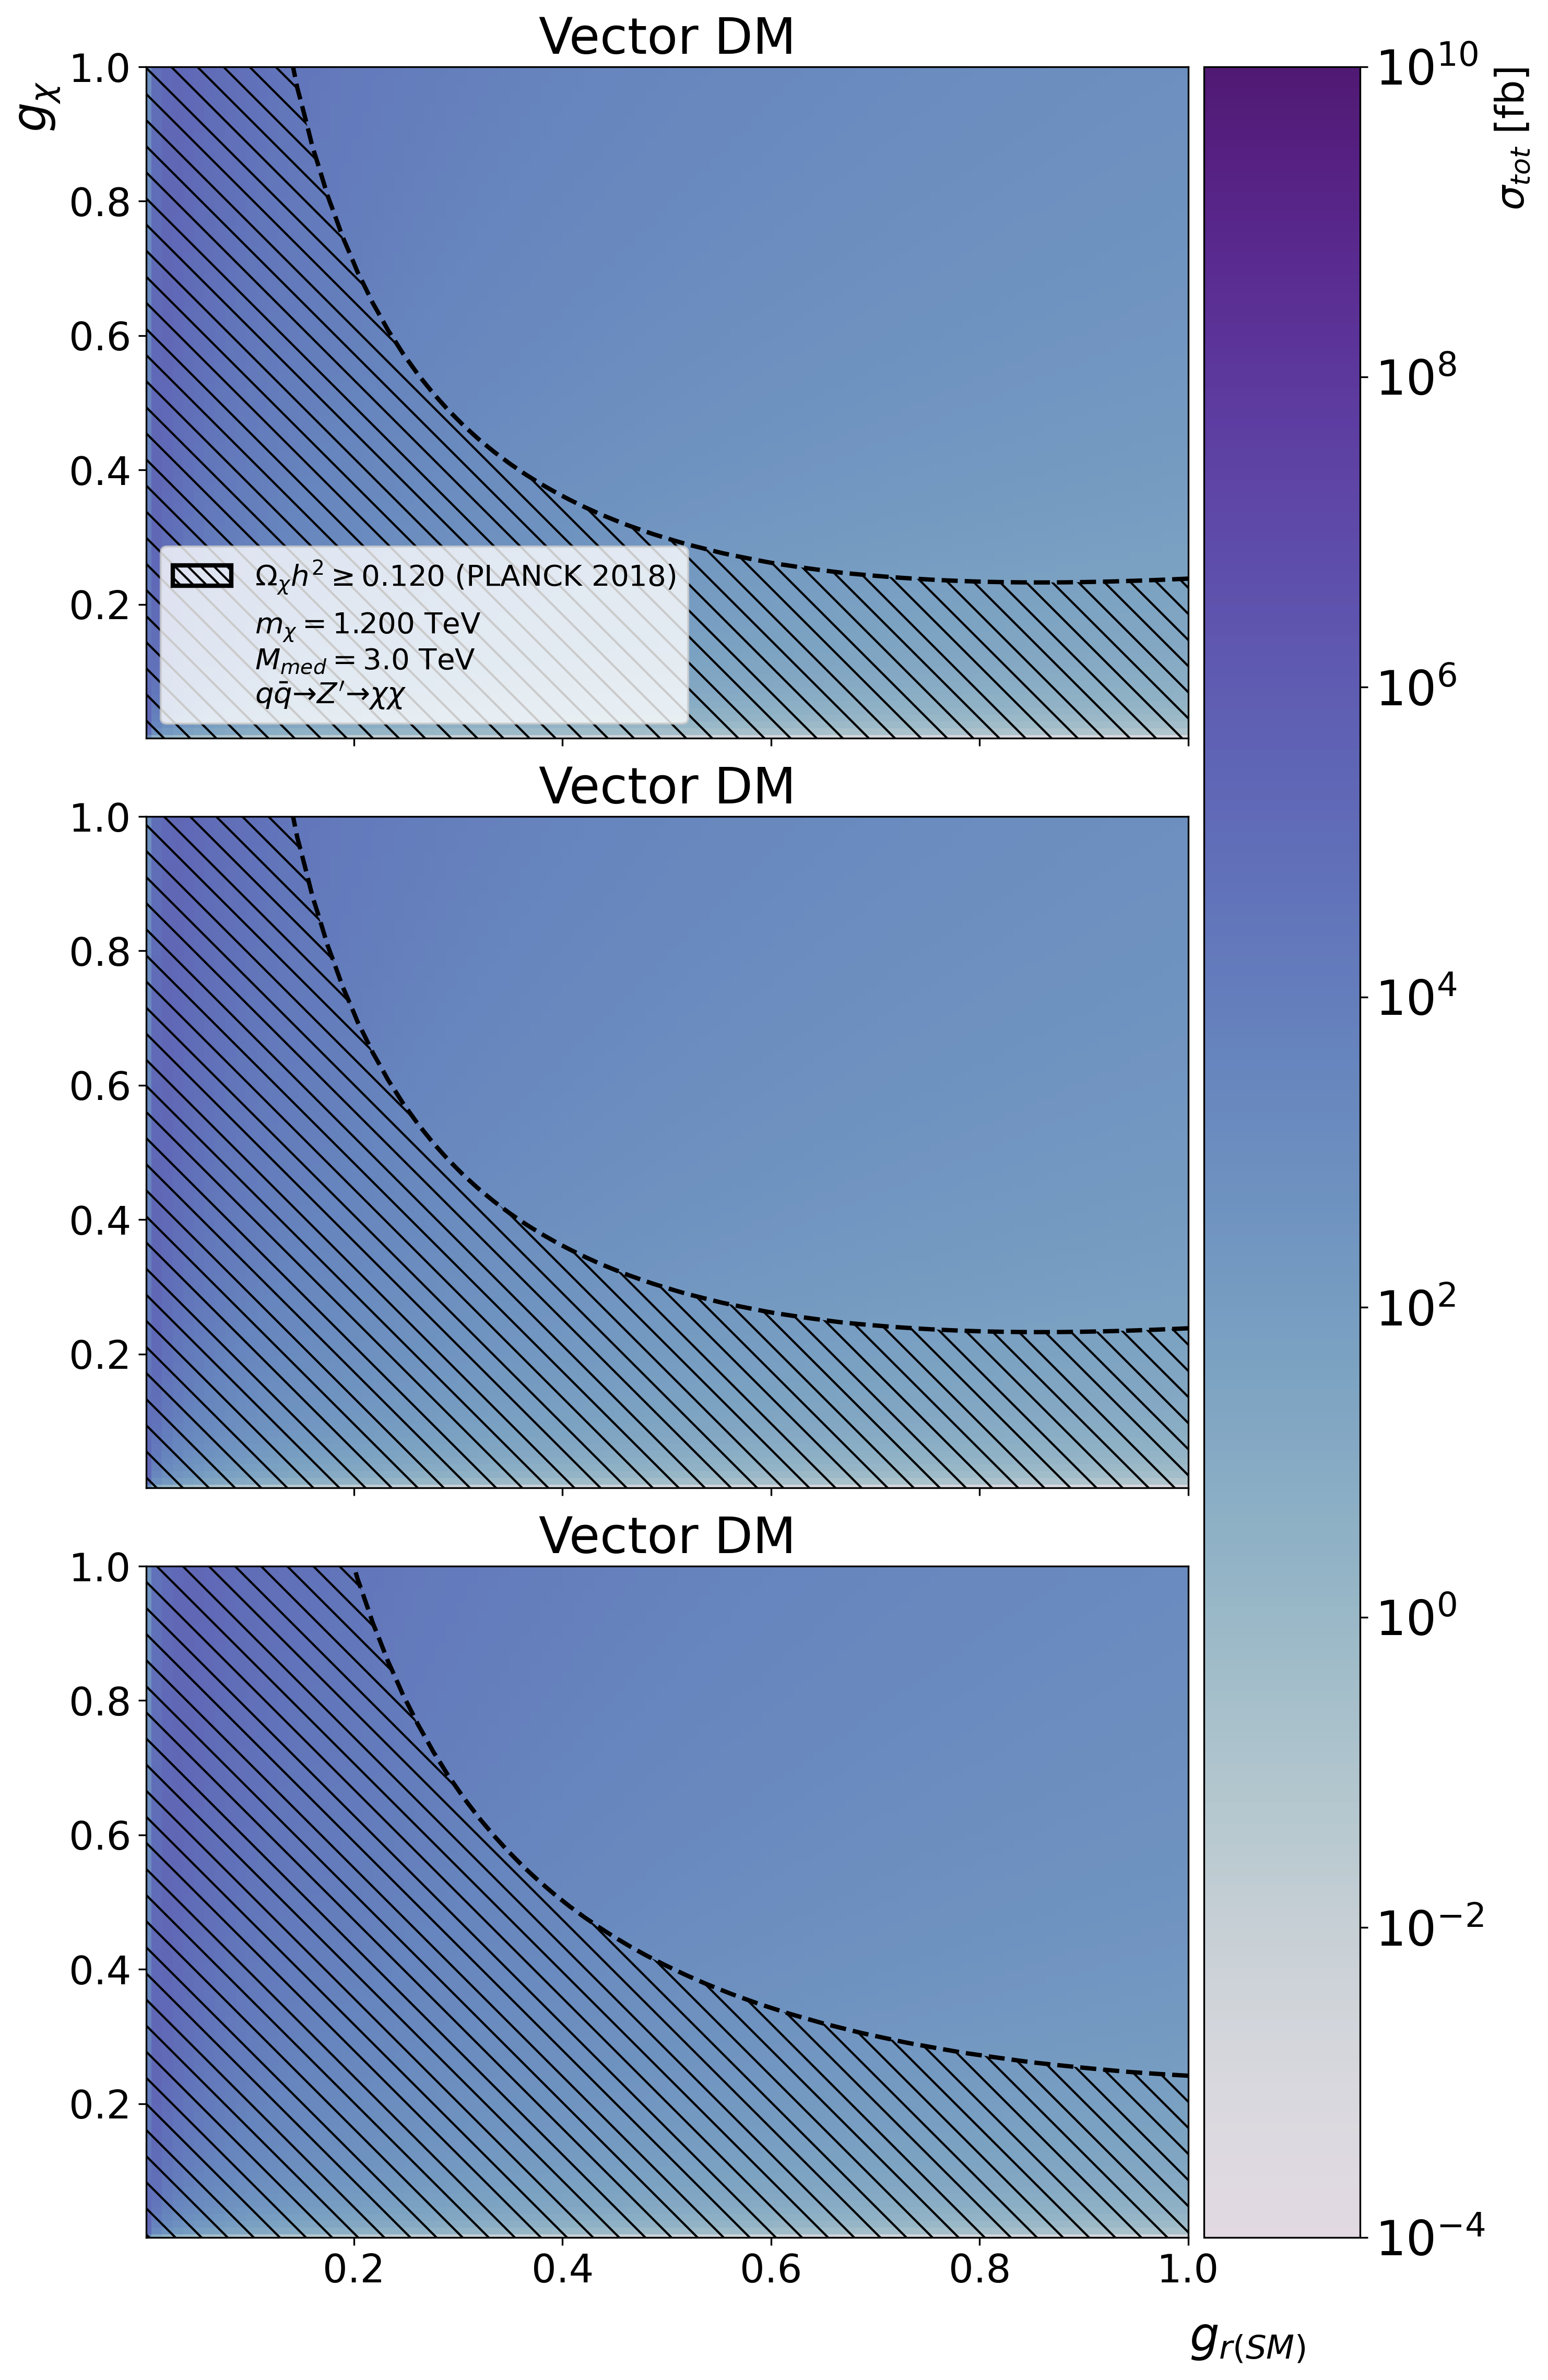

In [4]:
process = 'qq'
binsize_ohm = 70
mx = 1.2# (Mmed/2)*0.90 # DM mass [TeV]
omegarelic_coup = {}
for dmname in newdm_list:
    omegarelic_coup[dmname]  = gp.load_obj(f'./myruns/{today}_omegarelic_coup_{process}_{dmname}_binsize_{binsize_ohm}_mx_{mx}.pkl')


binsize = 100
mx = (Mmed/2)*0.0 # DM mass [TeV]
mx = 1.2
sigmaz = {}
for dmname in newdm_list:
    sigmaz[dmname]  = gp.load_obj(f'./myruns/{today}_sigmaz_coup_{process}_{dmname}_binsize_{binsize}_mx_{mx}.pkl')
    #sigmaz[dmname]  = gp.load_obj(f'./myruns/2023-10-28_sigmaz_coup_qq_{dmname}_binsize_100.pkl')




cb2d.cb_coupling(process, f'coupxcoup-{process}-ISR_mx_{mx}', sigmaz, omegarelic_coup, newdm_list, fix_scale=True, cmap=new_cmap_ee, vmin=10**-4, vmax=10**10, folder = '../figures/vector-plots', figsize=(10, 18))

---
---

# CMS - Relic

## qq -  coup x Mmed

### Naive relic

In [223]:
binsize_ohm = 100
###################################################
###################################################

#mx = (Mmed/2)*0.80 # DM mass [TeV]

#smax = Mmed**2

#gr = 0.25 #np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling

dM = 1/binsize_ohm 
#dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.linspace(Mmed_min, Mmed_max, binsize_ohm)

mx = Mmed_arr / 3

## CMS coupling
gx = 1 #np.geomspace(1E-3, 1, binsize_ohm) # DM coupling
gr = 0.25
gx_arr = np.geomspace(0.001, 2, binsize_ohm) # DM coupling
gr_arr = np.geomspace(0.001, 1, binsize_ohm) # DM coupling
# Define a grid
#Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx) 

Mmed_grid, gr_grid = np.meshgrid(Mmed_arr, gr_arr)

Mmed_grid, gx_grid = np.meshgrid(Mmed_arr, gx_arr)
omegarelic_coup = {}

print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 
#Nf_x = 18

#smax = 4*mx**2
me = gp.me

#me = 0.001
for dmname in ['Vector']:

    omegarelic_coup[dmname] = {}

    for gc in ['gx', 'gr']:
    
        omegarelic_coup[dmname][gc] = {}

        if gc == 'gx': #vetorial: gl = gr 
            param_lst = [smax, me, Mmed_grid, Mmed_grid/3, gr, gr, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][gc]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][gc]['data'] = ohm.super_naive(4*(Mmed_grid/3)**2, me, Mmed_grid , Mmed_grid/3, gr, gr, gx_grid, dmname, Nf_x)

        elif gc == 'gr': #  ## vector case only (gr = gl)
            param_lst = [smax, me, Mmed_grid, Mmed_grid/3, gr_grid, gr_grid, gx, dmname, Nf_x]
            omegarelic_coup[dmname][gc]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][gc]['data'] = ohm.super_naive(4*(Mmed_grid/3)**2, me, Mmed_grid , Mmed_grid/3, gr_grid, gr_grid, gx, dmname, Nf_x)



    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_naive_relic_CMS_{dmname}_comp_coupling_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')



Doing coupling...
Objeto salvo em ./myruns/2023-12-28_naive_relic_CMS_Fermion_comp_coupling_binsize_100.pkl
Done for Fermion


### Gondolo relic

In [25]:
## My code for coupling
binsize_ohm = 100
###################################################
###################################################

#mx = (Mmed/2)*0.80 # DM mass [TeV]

#smax = Mmed**2

#gr = 0.25 #np.linspace(1E-3, 1, binsize_ohm) # right SM/DM coupling

dM = 1/binsize_ohm 
#dmx = 0.5/binsize_ohm 
#Mediator mass [Tev] # 
Mmed_min = 0.001
Mmed_max = 5.1
Mmed_arr = np.linspace(Mmed_min, Mmed_max, binsize_ohm)

mx = Mmed_arr / 3

## CMS coupling
gx = 1 #np.geomspace(1E-3, 1, binsize_ohm) # DM coupling
gr = 0.25
gx_arr = np.geomspace(0.001, 2, binsize_ohm) # DM coupling
gr_arr = np.geomspace(0.001, 1, binsize_ohm) # DM coupling
# Define a grid
#Mmed_grid, mx_grid = np.meshgrid(Mmed_arr, mx) 

Mmed_grid, gr_grid = np.meshgrid(Mmed_arr, gr_arr)

Mmed_grid, gx_grid = np.meshgrid(Mmed_arr, gx_arr)
omegarelic_coup = {}

print('Doing coupling...')
row = 0
#  ## axial: gl = -gr ## chiral: gl = 0
process = 'qq'
Nf_x = gp.Nf_ee if process == 'ee' else gp.Nf_qq 
#Nf_x = 18

#smax = 4*mx**2
me = gp.me
for dmname in ['Vector']:

    omegarelic_coup[dmname] = {}

    for gc in ['gx', 'gr']:
        print(f'Doing coupling {dmname} {gc}')
        omegarelic_coup[dmname][gc] = {}

        if gc == 'gx': #vetorial: gl = gr 
            param_lst = [4*(Mmed_grid/3)**2, me, Mmed_grid, Mmed_grid/3, gr, gr, gx_grid, dmname, Nf_x]
            omegarelic_coup[dmname][gc]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][gc]['data'] = ohm.Ohm_numerical(4*(Mmed_grid/3)**2, me, Mmed_grid , Mmed_grid/3, gr, gr, gx_grid, dmname, Nf_x)

        elif gc == 'gr': #  ## vector case only (gr = gl)
            param_lst = [4*(Mmed_grid/3)**2, me, Mmed_grid, Mmed_grid/3, gr_grid, gr_grid, gx, dmname, Nf_x]
            omegarelic_coup[dmname][gc]['params'] = dict(zip(['s', 'mq', 'Mmed', 'mx', 'gr', 'gl', 'gx', 'dmname', 'Nf'], param_lst))

            omegarelic_coup[dmname][gc]['data'] = ohm.Ohm_numerical(4*(Mmed_grid/3)**2, me, Mmed_grid , Mmed_grid/3, gr_grid, gr_grid, gx, dmname, Nf_x)



    gp.save_obj(omegarelic_coup[dmname], f'./myruns/{today}_relic_CMS_{dmname}_comp_coupling_binsize_{binsize_ohm}.pkl')
    print(f'Done for {dmname}')

Doing coupling...
Doing coupling Vector gx
Doing coupling Vector gr
Objeto salvo em ./myruns/2024-01-03_relic_CMS_Vector_comp_coupling_binsize_100.pkl
Done for Vector


### g x mmed coupling plot

Fermion
gx
0
Fermion
gr
1


/tmp/ipykernel_25215/467261449.py:48: UserWarning: The following kwargs were not used by contour: 'rasterized'
  countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm, gc_grid_ohm, data_object[dmname][gc]['data'], ohm.planckdata1, colors='k', linewidths=2, linestyles='dashed', rasterized=True)
/tmp/ipykernel_25215/467261449.py:52: UserWarning: The following kwargs were not used by contour: 'rasterized'
  countour_relic_line = ax[fignumber].contour(Mmed_grid_ohm2, gc_grid_ohm2, data_object2[dmname][gc]['data'], ohm.planckdata1, colors='blue', linewidths=2, linestyles='solid', rasterized=True)


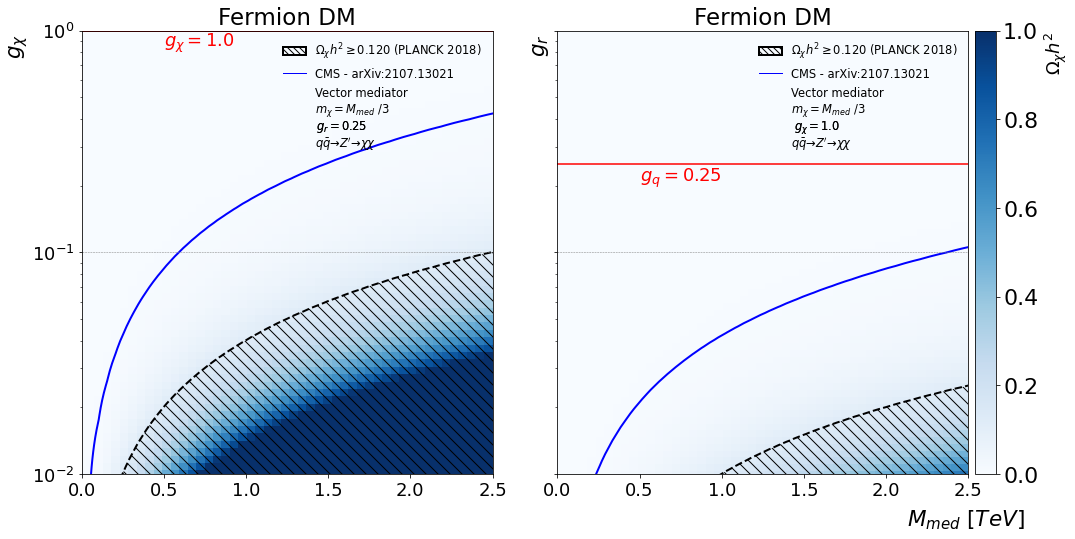

In [282]:
process = 'qq'
binsize_ohm = 100
omegarelic_coup = {}
for dmname in sig0.dmnames:
    omegarelic_coup[dmname]  = gp.load_obj(f'./myruns/{today}_relic_CMS_Fermion_comp_coupling_binsize_{binsize_ohm}.pkl')
# --------------------------------------------------------------------------------------------------------------------------------------------------------

process = 'qq'
binsize_ohm = 100
omegarelic_coup2 = {}
for dmname in sig0.dmnames:
    omegarelic_coup2[dmname]  = gp.load_obj(f'./myruns/{today}_naive_relic_CMS_Fermion_comp_coupling_binsize_{binsize_ohm}.pkl')

# --------------------------------------------------------------------------------------------------------------------------------------------------------

#cb2d.cb_plot3x3_relic_Mmed(process, f'omega-relic-{process}-Mmed-coup', omegarelic_coup, sig0.dmnames)


cb2d.cb_relic_Mmed_gr(process, f'naive-omega-relic-{process}-Mmed-coup', omegarelic_coup, sig0.dmnames, data_object2=omegarelic_coup2 )